In [1]:
from github import Github
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

ROLLING_WINDOW = 5

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio', 'Date'],
      dtype='object')


FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2020-10-06 04:23:33  33.93911   
1   NaN    NaN            NaN        Albania  2020-10-06 04:23:33  41.15330   

       Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  67.709953    39422.0  1466.0    32879.0  5077.0  Afghanistan   
1  20.168300    14410.0   400.0     8825.0  5185.0      Albania   

   Incidence_Rate  Case-Fatality_Ratio       Date  
0      101.268122             3.718736 2020-10-05  
1      500.729724             2.775850 2020-10-05

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    6897
unique                    209
top       2020-06-14 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-10-05 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incidence_Rate  Case-Fatality_Ratio       Date  
211             NaN                  NaN 2020-03-12  
212             NaN                  NaN 2020-03-1

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     209
unique                    209
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-10-05 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     229
unique                    229
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-10-05 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS                Admin2         Province_State Country_Region  \
201       NaN                   NaN                    NaN         France   
568       NaN                   NaN                    NaN         Serbia   
573       NaN                   NaN                    NaN       Slovenia   
2196  29099.0             Jefferson               Missouri             US   
201       NaN                   NaN                    NaN         France   
...       ...                   ...                    ...            ...   
3186      NaN                   NaN   Prince Edward Island         Canada   
3187      NaN                   NaN  Northwest Territories         Canada   
3188      NaN                   NaN       Diamond Princess         Canada   
3415  11001.0  District of Columbia   District of Columbia             US   
3416  53023.0       Garfield County             Washington             US   

              Last_Update        Lat       Long_  Confirmed   Deaths  \
201   2020-10-06 04:23:33  46.227600    2.213700   636196.0  32096.0   
568   2020-10-06 04:23:33  44.016500   21.005900    33952.0    756.0   
573   2020-10-06 04:23:33  46.151200   14.995500     6673.0    156.0   
2196  2020-10-06 04:23:33  38.259268  -90.538709     4762.0     66.0   
201   2020-10-05 04:23:33  46.227600    2.213700   601971.0  31952.0   
...                   ...        ...         ...        ...      ...   
3186        3/22/20 23:48  46.510700  -63.416800        3.0      0.0   
3187        3/22/20 23:48        NaN         NaN        1.0      0.0   
3188        3/22/20 23:48   0.000000    0.000000        0.0      1.0   
3415        3/22/20 23:45  38.904178  -77.016560      102.0      2.0   
3416        3/22/20 23:45  46.451975 -117.545403        1.0      2.0   

      Recovered    Active                                  Combined_Key  \
201     80394.0  523611.0                                        France   
568         0.0   33147.0                                        Serbia   
573      4265.0    2103.0                                      Slovenia   
2196        0.0    4497.0                       Jefferson, Missouri, US   
201     80061.0  490281.0                                        France   
...         ...       ...                                           ...   
3186        0.0       0.0                  Prince Edward Island, Canada   
3187        0.0       0.0                 Northwest Territories, Canada   
3188        0.0       0.0                      Diamond Princess, Canada   
3415        0.0       0.0  District of Columbia,District of Columbia,US   
3416        0.0       0.0                 Garfield County,Washington,US   

      Incidence_Rate  Case-Fatality_Ratio       Date  
201       974.445806             5.044986 2020-10-05  
568       388.000050             2.226673 2020-10-05  
573       316.171958             2.337779 2020-10-05  
2196     2027.270183             1.385972 2020-10-05  
201       921.851731             5.307897 2020-10-04  
...              ...                  ...        ...  
3186             NaN                  NaN 2020-03-22  
3187             NaN                  NaN 2020-03-22  
3188             NaN                  NaN 2020-03-22  
3415             NaN                  NaN 2020-03-22  
3416             NaN                  NaN 2020-03-22  

[44536 rows x 15 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40672 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            40672 non-null  float64
 1   Deaths               40672 non-null  float64
 2   Recovered            40672 non-null  float64
 3   Active               40672 non-null  float64
 4   Incidence_Rate       40672 non-null  float64
 5   Case-Fatality_Ratio  40672 non-null  float64
dtypes: float64(6)
memory usage: 2.0+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  
Country_Region Date                                             
 Azerbaijan    2020-02-28             0.0                  0.0  
Afghanistan    2020-02-24             0.0                  0.0  
               2020-02-25             0.0                  0.0  
               2020-02-26             0.0                  0.0  
               2020-02-27             0.0                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'India', 'Brazil', 'Russia', 'Colombia', 'Peru', 'Spain',
       'Argentina', 'Mexico', 'South Africa', 'France', 'United Kingdom',
       'Iran', 'Chile', 'Iraq', 'Bangladesh', 'Saudi Arabia', 'Italy',
       'Turkey', 'Philippines', 'Pakistan', 'Indonesia', 'Israel', 'Germany',
       'Ukraine', 'Canada', 'Ecuador', 'Netherlands', 'Romania', 'Bolivia',
       'Morocco', 'Belgium', 'Qatar', 'Panama', 'Dominican Republic',
       'Kazakhstan', 'Kuwait', 'Egypt', 'Poland', 'Oman',
       'United Arab Emirates', 'Sweden', 'Guatemala', 'China', 'Nepal',
       'Japan', 'Czechia', 'Costa Rica', 'Belarus', 'Honduras'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran', 'Bolivia']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))
print()
print('\n'.join(c for c in population.index if 'Venezuela' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)

Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11400 entries, ('Argentina', Timestamp('2020-03-03 00:00:00')) to ('United Kingdom', Timestamp('2020-10-05 00:00:00'))
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            11400 non-null  float64
 1   Deaths               11400 non-null  float64
 2   Recovered            11400 non-null  float64
 3   Active               11400 non-null  float64
 4   Incidence_Rate       11400 non-null  float64
 5   Case-Fatality_Ratio  11400 non-null  float64
 6   Confirmed_per_100k   11400 non-null  float64
 7   Deaths_per_100k      11400 non-null  float64
 8   Recovered_per_100k   11400 non-null  float64
 9   Active_per_100k      11400 non-null  float64
dtypes: float64(10)
memory usage: 939.1+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        1.0     0.0        0.0     1.0   
               2020-03-04        1.0     0.0        0.0     1.0   
               2020-03-05        1.0     0.0        0.0     1.0   
               2020-03-06        2.0     0.0        0.0     2.0   
               2020-03-07        8.0     0.0        0.0     8.0   

                           Incidence_Rate  Case-Fatality_Ratio  \
Country_Region Date                                              
Argentina      2020-03-03             0.0                  0.0   
               2020-03-04             0.0                  0.0   
               2020-03-05             0.0                  0.0   
               2020-03-06             0.0                  0.0   
               2020-03-07             0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03            0.002233              0.0   
               2020-03-04            0.002233              0.0   
               2020-03-05            0.002233              0.0   
               2020-03-06            0.004466              0.0   
               2020-03-07            0.017865              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 0.0         0.002233  
               2020-03-04                 0.0         0.002233  
               2020-03-05                 0.0         0.002233  
               2020-03-06                 0.0         0.004466  
               2020-03-07                 0.0         0.017865

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Argentina to United Kingdom
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incidence_Rate           50 non-null     float64
 5   Case-Fatality_Ratio      50 non-null     float64
 6   Confirmed_per_100k       50 non-null     float64
 7   Deaths_per_100k          50 non-null     float64
 8   Recovered_per_100k       50 non-null     float64
 9   Active_per_100k          50 non-null     float64
 10  population               50 non-null     float64
 11  recovered_per_confirmed  50 non-null     float64
 12  deaths_per_confirmed     50 non-null     float64
dtypes: float64(13)
memory usage: 5.5+ KB


Confirmed    Deaths  Recovered     Active  \
Country_Region                                                    
Argentina              809728.0   21468.0   649017.0   144575.0   
Bangladesh             370132.0    5375.0   283182.0   115779.0   
Belarus                 80696.0     862.0    75303.0    25477.0   
Belgium                132203.0   10078.0    19712.0   102413.0   
Bolivia                137107.0    8129.0    98007.0    60928.0   
Brazil                4927235.0  146675.0  4397882.0   598313.0   
Canada                 171384.0    9560.0   144653.0    36033.0   
Chile                  471746.0   13037.0   443453.0    95631.0   
China                   90652.0    4739.0    85540.0    58046.0   
Colombia               862158.0   26844.0   766300.0   169326.0   
Costa Rica              81129.0     987.0    49703.0    43461.0   
Czechia                 85566.0     758.0    46636.0    42320.0   
Dominican Republic     115054.0    2144.0    90942.0    35057.0   
Ecuador                141339.0   11681.0   120511.0    44283.0   
Egypt                  103781.0    5990.0    97398.0    55230.0   
France                 664289.0   32317.0   100873.0   531099.0   
Germany                236745.0    9203.0   208115.0    72864.0   
Guatemala               94182.0    3302.0    82828.0    27377.0   
Honduras                80020.0    2433.0    29768.0    49586.0   
India                 6685082.0  103569.0  5662490.0  1017754.0   
Indonesia              307120.0   11253.0   232593.0    63894.0   
Iran                   475674.0   27192.0   392293.0    56189.0   
Iraq                   382949.0    9464.0   312158.0    63157.0   
Israel                 272309.0    1757.0   204355.0    72400.0   
Italy                  327586.0   36002.0   232681.0   108257.0   
Japan                   86027.0    1602.0    78071.0    17240.0   
Kazakhstan             108296.0    1725.0   103367.0    34497.0   
Kuwait                 107592.0     628.0    99549.0    15831.0   
Mexico                 789780.0   81877.0   670034.0    53350.0   
Morocco                134695.0    2369.0   113336.0    20258.0   
Nepal                   89263.0     554.0    65202.0    23507.0   
Netherlands            141258.0    6509.0     4492.0   130337.0   
Oman                   101814.0     985.0    90600.0    23276.0   
Pakistan               315727.0    6523.0   300616.0   108642.0   
Panama                 115919.0    2430.0    92423.0    25549.0   
Peru                   828169.0   32742.0   706223.0   168092.0   
Philippines            324762.0    5840.0   273123.0    83109.0   
Poland                 102080.0    2659.0    73552.0    25869.0   
Qatar                  126692.0     216.0   123664.0    35634.0   
Romania                137491.0    5048.0   108526.0    61134.0   
Russia                1219796.0   21375.0   978610.0   245382.0   
Saudi Arabia           336766.0    4898.0   322055.0    63026.0   
South Africa           682215.0   17016.0   615684.0   173590.0   
Spain                  813412.0   32225.0   150376.0   630811.0   
Sweden                  94283.0    5895.0     4971.0    88388.0   
Turkey                 326046.0    8498.0   286370.0    80808.0   
US                    7457402.0  210181.0  2935142.0  4312079.0   
Ukraine                236329.0    4530.0   104966.0   126833.0   
United Arab Emirates    99733.0     429.0    89410.0    17173.0   
United Kingdom         518222.0   46791.0     2409.0   473354.0   

                      Incidence_Rate  Case-Fatality_Ratio  Confirmed_per_100k  \
Country_Region                                                                  
Argentina               1.791601e+03             3.372463         1808.208563   
Bangladesh              2.247455e+02             1.452185          227.010541   
Belarus                 8.539873e+02             1.068207          853.708298   
Belgium                 1.140702e+03            16.247214         1145.673499   
Bolivia                 1.174562e+03             5.

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                           
US                    7457402.0  210181.0
India                 6685082.0  103569.0
Brazil                4927235.0  146675.0
Russia                1219796.0   21375.0
Colombia               862158.0   26844.0
Peru                   828169.0   32742.0
Spain                  813412.0   32225.0
Argentina              809728.0   21468.0
Mexico                 789780.0   81877.0
South Africa           682215.0   17016.0
France                 664289.0   32317.0
United Kingdom         518222.0   46791.0
Iran                   475674.0   27192.0
Chile                  471746.0   13037.0
Iraq                   382949.0    9464.0
Bangladesh             370132.0    5375.0
Saudi Arabia           336766.0    4898.0
Italy                  327586.0   36002.0
Turkey                 326046.0    8498.0
Philippines            324762.0    5840.0
Pakistan               315727.0    6523.0
Indonesia              307120.0   11253.0
Israel                 272309.0    1757.0
Germany                236745.0    9203.0
Ukraine                236329.0    4530.0
Canada                 171384.0    9560.0
Ecuador                141339.0   11681.0
Netherlands            141258.0    6509.0
Romania                137491.0    5048.0
Bolivia                137107.0    8129.0
Morocco                134695.0    2369.0
Belgium                132203.0   10078.0
Qatar                  126692.0     216.0
Panama                 115919.0    2430.0
Dominican Republic     115054.0    2144.0
Kazakhstan             108296.0    1725.0
Kuwait                 107592.0     628.0
Egypt                  103781.0    5990.0
Poland                 102080.0    2659.0
Oman                   101814.0     985.0
United Arab Emirates    99733.0     429.0
Sweden                  94283.0    5895.0
Guatemala               94182.0    3302.0
China                   90652.0    4739.0
Nepal                   89263.0     554.0
Japan                   86027.0    1602.0
Czechia                 85566.0     758.0
Costa Rica              81129.0     987.0
Belarus                 80696.0     862.0
Honduras                80020.0    2433.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k  Confirmed    Deaths
Country_Region                                               
Qatar                        4473.475418   126692.0     216.0
Israel                       3196.350248   272309.0    1757.0
Panama                       2729.792485   115919.0    2430.0
Kuwait                       2557.405058   107592.0     628.0
Peru                         2547.392283   828169.0   32742.0
Chile                        2489.157497   471746.0   13037.0
Brazil                       2334.634556  4927235.0  146675.0
US                           2266.240372  7457402.0  210181.0
Oman                         2046.515854   101814.0     985.0
Argentina                    1808.208563   809728.0   21468.0
Spain                        1740.410797   813412.0   32225.0
Colombia                     1712.688796   862158.0   26844.0
Costa Rica                   1607.291125    81129.0     987.0
Bolivia                      1190.878010   137107.0    8129.0
South Africa                 1165.019108   682215.0   17016.0
Belgium                      1145.673499   132203.0   10078.0
Dominican Republic           1071.370339   115054.0    2144.0
United Arab Emirates         1020.753642    99733.0     429.0
France                       1019.947403   664289.0   32317.0
Saudi Arabia                  982.726746   336766.0    4898.0
Iraq                          974.182283   382949.0    9464.0
Sweden                        939.411388    94283.0    5895.0
Belarus                       853.708298    80696.0     862.0
Russia                        836.208337  1219796.0   21375.0
Netherlands                   826.209182   141258.0    6509.0
Honduras                      821.045104    80020.0    2433.0
Ecuador                       813.524752   141339.0   11681.0
Czechia                       800.489241    85566.0     758.0
United Kingdom                767.393402   518222.0   46791.0
Romania                       710.013624   137491.0    5048.0
Mexico                        619.068568   789780.0   81877.0
Kazakhstan                    583.760991   108296.0    1725.0
Iran                          573.696377   475674.0   27192.0
Italy                         541.016519   327586.0   36002.0
Ukraine                       537.188975   236329.0    4530.0
Guatemala                     535.688812    94182.0    3302.0
India                         489.241447  6685082.0  103569.0
Canada                        458.110785   171384.0    9560.0
Turkey                        390.803711   326046.0    8498.0
Morocco                       369.313074   134695.0    2369.0
Nepal                         312.013315    89263.0     554.0
Philippines                   300.381194   324762.0    5840.0
Germany                       283.469078   236745.0    9203.0
Poland                        269.427304   102080.0    2659.0
Bangladesh                    227.010541   370132.0    5375.0
Pakistan                      145.788349   315727.0    6523.0
Indonesia                     113.485213   307120.0   11253.0
Egypt                         103.379808   103781.0    5990.0
Japan                          67.812389    86027.0    1602.0
China                           6.322572    90652.0    4739.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                 
Italy                  327586.0   36002.0              0.109901
Mexico                 789780.0   81877.0              0.103671
United Kingdom         518222.0   46791.0              0.090291
Ecuador                141339.0   11681.0              0.082645
Belgium                132203.0   10078.0              0.076231
Sweden                  94283.0    5895.0              0.062525
Bolivia                137107.0    8129.0              0.059289
Egypt                  103781.0    5990.0              0.057718
Iran                   475674.0   27192.0              0.057165
Canada                 171384.0    9560.0              0.055781
China                   90652.0    4739.0              0.052277
France                 664289.0   32317.0              0.048649
Netherlands            141258.0    6509.0              0.046079
Spain                  813412.0   32225.0              0.039617
Peru                   828169.0   32742.0              0.039535
Germany                236745.0    9203.0              0.038873
Romania                137491.0    5048.0              0.036715
Indonesia              307120.0   11253.0              0.036640
Guatemala               94182.0    3302.0              0.035060
Colombia               862158.0   26844.0              0.031136
Honduras                80020.0    2433.0              0.030405
Brazil                4927235.0  146675.0              0.029768
US                    7457402.0  210181.0              0.028184
Chile                  471746.0   13037.0              0.027636
Argentina              809728.0   21468.0              0.026513
Turkey                 326046.0    8498.0              0.026064
Poland                 102080.0    2659.0              0.026048
South Africa           682215.0   17016.0              0.024942
Iraq                   382949.0    9464.0              0.024713
Panama                 115919.0    2430.0              0.020963
Pakistan               315727.0    6523.0              0.020660
Ukraine                236329.0    4530.0              0.019168
Dominican Republic     115054.0    2144.0              0.018635
Japan                   86027.0    1602.0              0.018622
Philippines            324762.0    5840.0              0.017982
Morocco                134695.0    2369.0              0.017588
Russia                1219796.0   21375.0              0.017523
Kazakhstan             108296.0    1725.0              0.015929
India                 6685082.0  103569.0              0.015493
Saudi Arabia           336766.0    4898.0              0.014544
Bangladesh             370132.0    5375.0              0.014522
Costa Rica              81129.0     987.0              0.012166
Belarus                 80696.0     862.0              0.010682
Oman                   101814.0     985.0              0.009675
Czechia                 85566.0     758.0              0.008859
Israel                 272309.0    1757.0              0.006452
Nepal                   89263.0     554.0              0.006206
Kuwait                 107592.0     628.0              0.005837
United Arab Emirates    99733.0     429.0              0.004301
Qatar                  126692.0     216.0              0.001705

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Confirmed_per_100k', 'Deaths_per_100k',
       'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

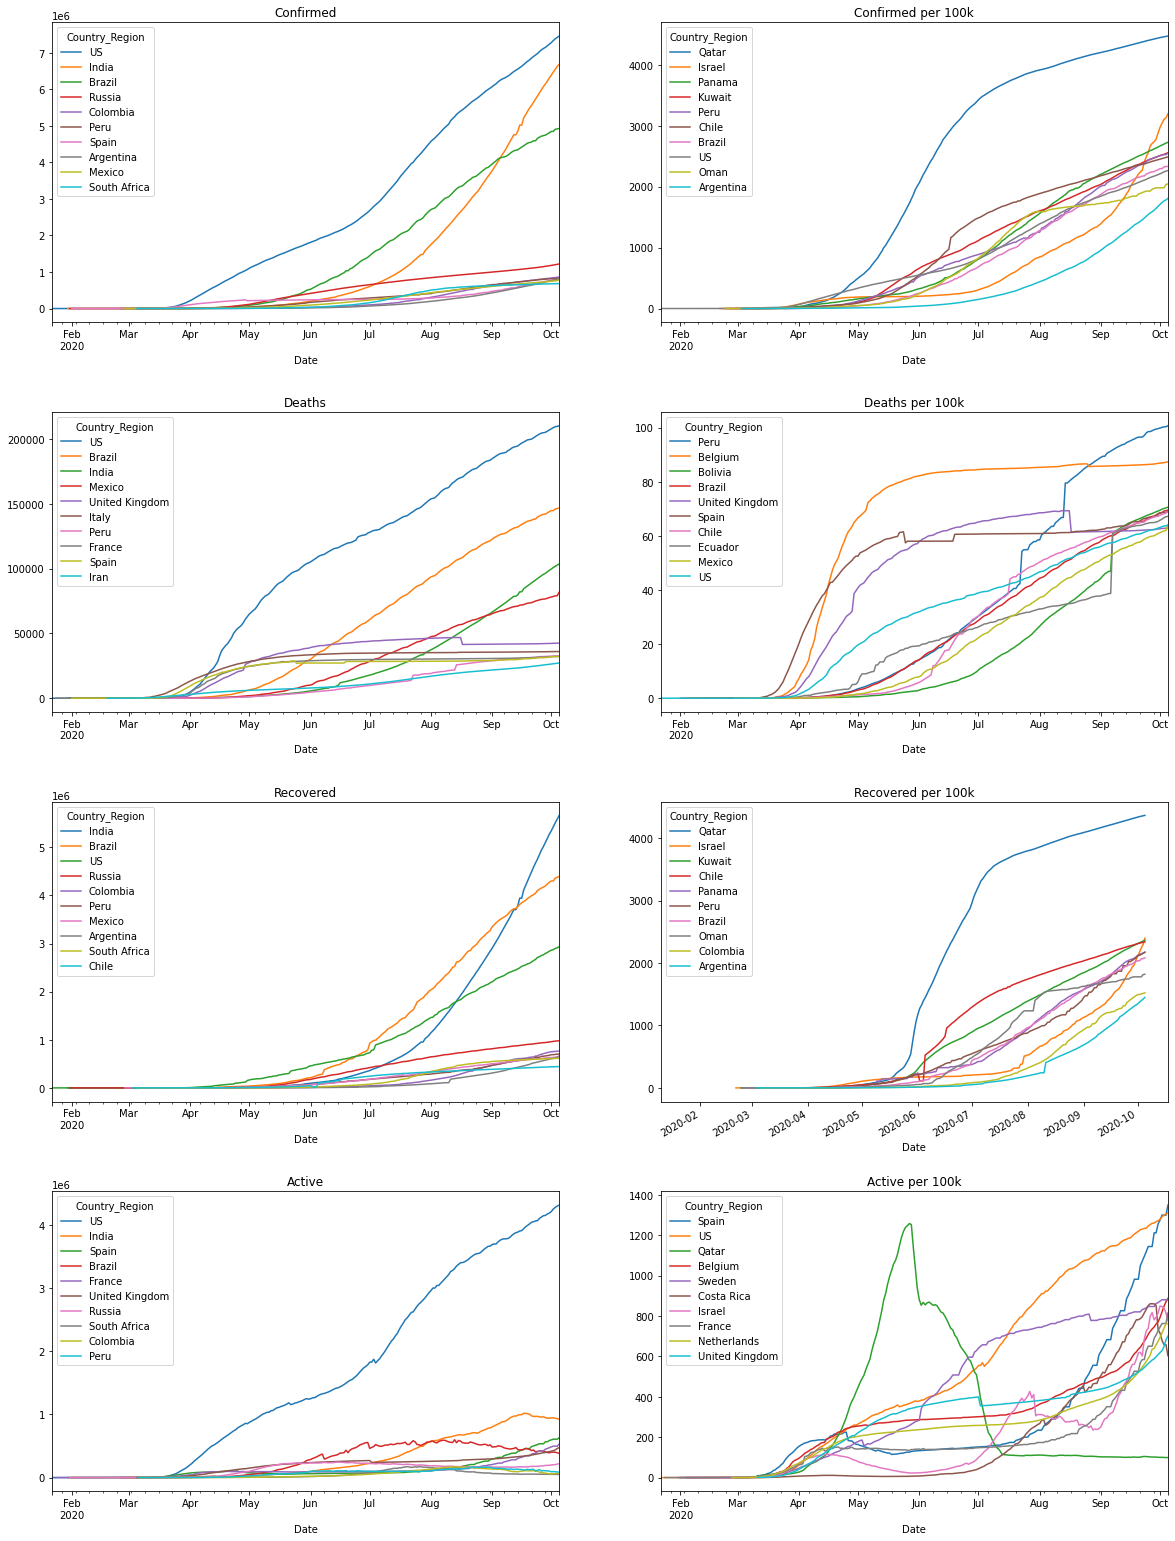

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

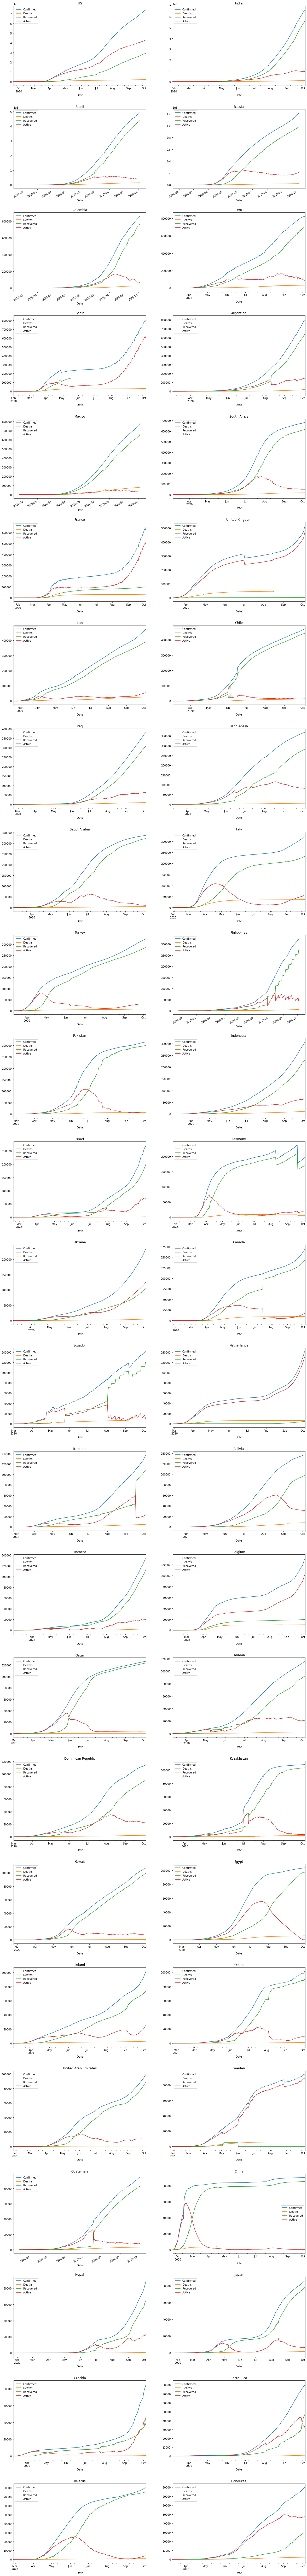

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=ROLLING_WINDOW).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Argentina      Argentina      2020-03-03        NaN     NaN        NaN   
                              2020-03-04        NaN     NaN        NaN   
                              2020-03-05        NaN     NaN        NaN   
                              2020-03-06        NaN     NaN        NaN   
                              2020-03-07        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-10-01     6191.6    46.4       10.0   
                              2020-10-02     6450.4    56.2       10.0   
                              2020-10-03     8216.2    63.4        8.8   
                              2020-10-04    11378.0    55.6        7.0   
                              2020-10-05    12475.2    45.2        7.2   

                                           Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                      
Argentina      Argentina      2020-03-03      NaN                 NaN   
                              2020-03-04      NaN                 NaN   
                              2020-03-05      NaN                 NaN   
                              2020-03-06      NaN                 NaN   
                              2020-03-07      NaN                 NaN   
...                                           ...                 ...   
United Kingdom United Kingdom 2020-10-01   6135.2            9.168644   
                              2020-10-02   6384.2            9.551880   
                              2020-10-03   8144.0           12.166712   
                              2020-10-04  11315.4           16.848768   
                              2020-10-05  12422.8           18.473523   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Argentina      Argentina      2020-03-03              NaN                 NaN   
                              2020-03-04              NaN                 NaN   
                              2020-03-05              NaN                 NaN   
                              2020-03-06              NaN                 NaN   
                              2020-03-07              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-10-01         0.068710            0.014808   
                              2020-10-02         0.083222            0.014808   
                              2020-10-03         0.093884            0.013031   
                              2020-10-04         0.082334            0.010366   
                              2020-10-05         0.066933            0.010662   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Argentina      Argentina      2020-03-03              NaN  
                              2020-03-04              NaN  
                              2020-03-05              NaN  
                              2020-03-06              NaN  
                              2020-03-07              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-10-01         9.085126  
                              2020-10-02         9.453850  
                              2020-10-03        12.059797  
                              2020-10-04        16.756068  
                              2020-10-05        18.395928  

[11400 rows x 8 columns]

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-03-03        NaN     NaN        NaN      NaN   
               2020-03-04        NaN     NaN        NaN      NaN   
               2020-03-05        NaN     NaN        NaN      NaN   
               2020-03-06        NaN     NaN        NaN      NaN   
               2020-03-07        NaN     NaN        NaN      NaN   
...                              ...     ...        ...      ...   
United Kingdom 2020-10-01     6191.6    46.4       10.0   6135.2   
               2020-10-02     6450.4    56.2       10.0   6384.2   
               2020-10-03     8216.2    63.4        8.8   8144.0   
               2020-10-04    11378.0    55.6        7.0  11315.4   
               2020-10-05    12475.2    45.2        7.2  12422.8   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-10-01            9.168644         0.068710   
               2020-10-02            9.551880         0.083222   
               2020-10-03           12.166712         0.093884   
               2020-10-04           16.848768         0.082334   
               2020-10-05           18.473523         0.066933   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-10-01            0.014808         9.085126  
               2020-10-02            0.014808         9.453850  
               2020-10-03            0.013031        12.059797  
               2020-10-04            0.010366        16.756068  
               2020-10-05            0.010662        18.395928  

[11400 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

217

In [43]:
d.iloc[len_of_first_group-ROLLING_WINDOW:len_of_first_group+ROLLING_WINDOW*2]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-10-01    12503.6   949.0     9330.2  2224.4   
               2020-10-02    13672.8   970.0     9716.0  2986.8   
               2020-10-03    13537.2   936.4     9879.8  2721.0   
               2020-10-04    12375.4   899.8    10163.0  1312.6   
               2020-10-05    11745.4   906.2    10874.4   -35.2   
Bangladesh     2020-03-08        NaN     NaN        NaN     NaN   
               2020-03-09        NaN     NaN        NaN     NaN   
               2020-03-10        NaN     NaN        NaN     NaN   
               2020-03-11        NaN     NaN        NaN     NaN   
               2020-03-12        NaN     NaN        NaN     NaN   
               2020-03-13        0.0     0.0        0.0     0.0   
               2020-03-14        0.0     0.0        0.0     0.0   
               2020-03-15        0.4     0.0        0.0     0.4   
               2020-03-16        1.0     0.0        0.4     0.6   
               2020-03-17        1.4     0.0        0.6     0.8   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-10-01           27.921866         2.119218   
               2020-10-02           30.532814         2.166113   
               2020-10-03           30.230004         2.091081   
               2020-10-04           27.635582         2.009349   
               2020-10-05           26.228725         2.023641   
Bangladesh     2020-03-08                 NaN              NaN   
               2020-03-09                 NaN              NaN   
               2020-03-10                 NaN              NaN   
               2020-03-11                 NaN              NaN   
               2020-03-12                 NaN              NaN   
               2020-03-13            0.000000         0.000000   
               2020-03-14            0.000000         0.000000   
               2020-03-15            0.000245         0.000000   
               2020-03-16            0.000613         0.000000   
               2020-03-17            0.000859         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-10-01           20.835327         4.967321  
               2020-10-02           21.696859         6.669841  
               2020-10-03           22.062642         6.076282  
               2020-10-04           22.695058         2.931175  
               2020-10-05           24.283689        -0.078605  
Bangladesh     2020-03-08                 NaN              NaN  
               2020-03-09                 NaN              NaN  
               2020-03-10                 NaN              NaN  
               2020-03-11                 NaN              NaN  
               2020-03-12                 NaN              NaN  
               2020-03-13            0.000000         0.000000  
               2020-03-14            0.000000         0.000000  
               2020-03-15            0.000000         0.000245  
               2020-03-16            0.000245         0.000368  
               2020-03-17            0.000368         0.000491

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-05-22    10649.0   433.0     3062.0   7154.0   
               2020-05-23    11353.0   445.0     3530.0   7378.0   
               2020-05-24    12076.0   452.0     3732.0   7892.0   
               2020-05-25    12628.0   467.0     3999.0   8162.0   
               2020-05-26    13228.0   484.0     4167.0   8577.0   
               2020-05-27    13933.0   500.0     4349.0   9084.0   
               2020-05-28    14702.0   508.0     4617.0   9577.0   
               2020-05-29    15419.0   520.0     4788.0  10111.0   
               2020-05-30    16214.0   528.0     4788.0  10898.0   
               2020-05-31    16851.0   539.0     5336.0  10976.0   
               2020-06-01    17415.0   556.0     5521.0  11338.0   
               2020-06-02    18319.0   569.0     5709.0  12041.0   
               2020-06-03    19268.0   583.0     5896.0  12789.0   
               2020-06-04    20197.0   608.0     5993.0  13596.0   
               2020-06-05    21037.0   632.0     6088.0  14317.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22           23.780347         0.966935   
               2020-05-23           25.352454         0.993732   
               2020-05-24           26.966990         1.009364   
               2020-05-25           28.199664         1.042861   
               2020-05-26           29.539528         1.080823   
               2020-05-27           31.113868         1.116553   
               2020-05-28           32.831126         1.134418   
               2020-05-29           34.432263         1.161215   
               2020-05-30           36.207583         1.179080   
               2020-05-31           37.630071         1.203644   
               2020-06-01           38.889543         1.241607   
               2020-06-02           40.908271         1.270637   
               2020-06-03           43.027489         1.301901   
               2020-06-04           45.102045         1.357729   
               2020-06-05           46.977854         1.411323   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22            6.837771        15.975641   
               2020-05-23            7.882865        16.475857   
               2020-05-24            8.333952        17.623674   
               2020-05-25            8.930191        18.226612   
               2020-05-26            9.305353        19.153351   
               2020-05-27            9.711779        20.285536   
               2020-05-28           10.310251        21.386457   
               2020-05-29           10.692112        22.578936   
               2020-05-30           10.692112        24.336391   
               2020-05-31           11.915854        24.510573   
               2020-06-01           12.328979        25.318957   
               2020-06-02           12.748803        26.888831   
               2020-06-03           13.166394        28.559194   
               2020-06-04           13.383005        30.361311   
               2020-06-05           13.595150        31.971381   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Argentina      2020-05-22           516.2         12.0            98.6   
               2020-05-23           596.4         12.6           181.0   
               2020-05-24           653.4         11.8           172.0   
               2020-05-25           669.0         12.8           213.2   
               2020-05-26           659.4         13.6           227.0   
               2020-05-27           656.8         13.4           257.4   
               2020-05-28       

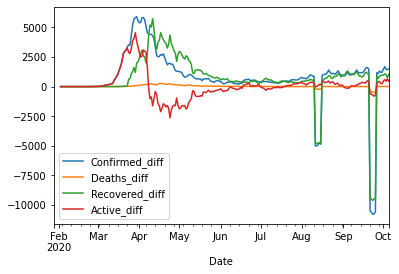

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

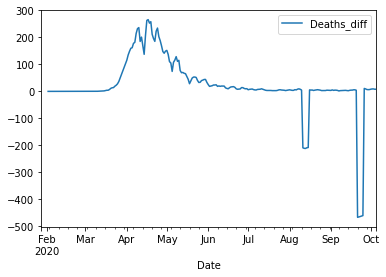

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

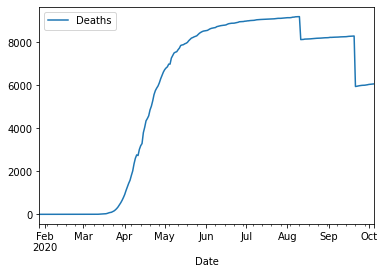

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

In [49]:
display(HTML(covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].to_html()))

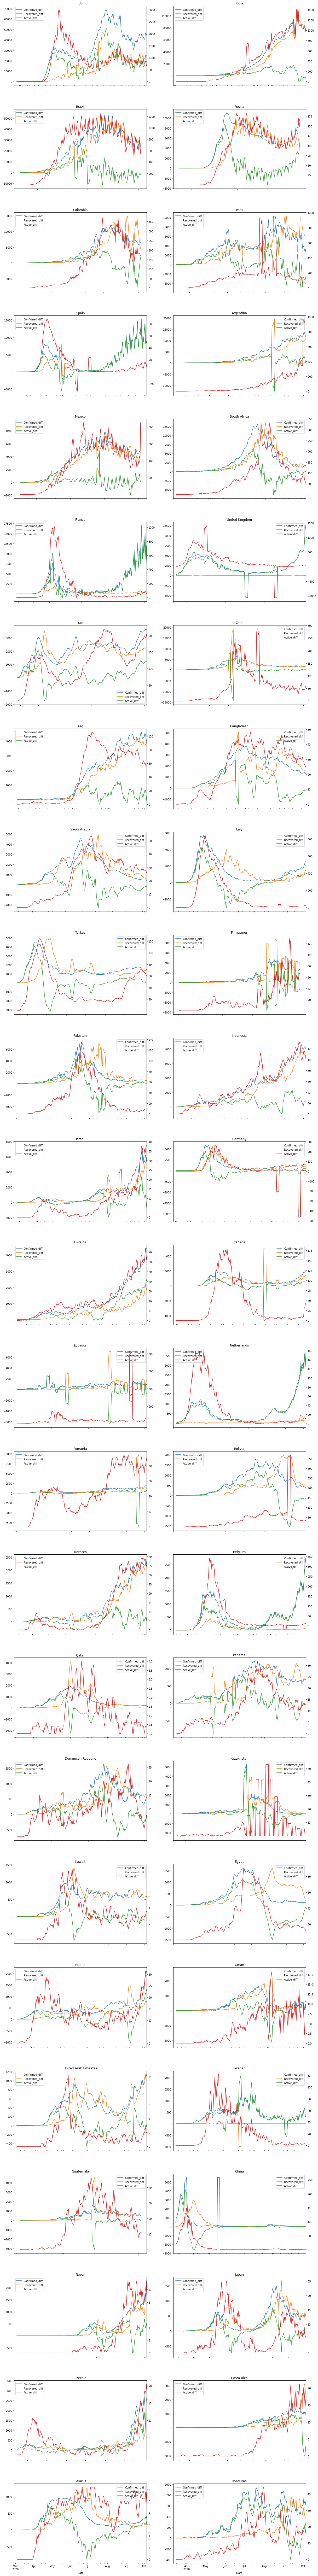

In [50]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)
    ax2=ax.twinx()
    covid.loc[country,['Deaths_diff']].plot(ax=ax2, colormap='Set1')
    ax2.get_legend().remove()
    
fig.subplots_adjust(hspace=0.3)

In [51]:
N_TOP_IMPACTED

50